<a href="https://colab.research.google.com/github/Untick/insects_detection/blob/main/Romashenkov%20Leonid/LR_U_Net_PSPNet_000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [ ]:
from tensorflow.keras.models import Model      # Импортируем модель keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization # Импортируем стандартные слои keras
from tensorflow.keras import backend as K      # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam   # Импортируем оптимайзер
from tensorflow.keras import utils             # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files                 # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt                # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # Импортируем модуль image для работы с изображениями
from keras.preprocessing import image
import numpy as np                             # Импортируем библиотеку numpy
import os                                      # Импортируем библиотеку os для работы с файловой системой
import random
from PIL import Image                          # Импортируем модель Image для работы с изображениями
from tensorflow.keras.callbacks import ModelCheckpoint  # Импортируем объект ModelCheckpoint для работы с сохранением модели сети

# Функция, которая смотрит на пересечение областей. Нужна для accuracy
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


# Download & expand data

In [ ]:
%pip install -q gdown

In [ ]:
import gdown

file_id = '13EP4J8R0zVXHUc31K0cAkJASHRgECEUM'
output_file = 'seg2.tgz'
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

Downloading...
From: https://drive.google.com/uc?id=13EP4J8R0zVXHUc31K0cAkJASHRgECEUM
To: /content/seg2.tgz
100%|██████████| 9.77M/9.77M [00:00<00:00, 68.0MB/s]


'seg2.tgz'

In [ ]:
!tar xzf 'seg2.tgz'
!ls -lh '/content/semantic.v3.2'

total 12K
-rw-r--r-- 1 1000 1000   62 Sep 15 12:41 classes.csv
drwxrwxr-x 2 1000 1000 4.0K Sep 18 12:10 img
drwxrwxr-x 2 1000 1000 4.0K Sep 18 12:11 mask


# GPU (Сначала сменить среду на Т4)

In [ ]:
!nvidia-smi

Thu Sep 28 10:11:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       1.0Gi       9.3Gi       1.0Mi       2.3Gi        11Gi
Swap:             0B          0B          0B


In [ ]:
!cat /proc/cpuinfo | grep processor

processor	: 0
processor	: 1


# Классы

In [ ]:
import pandas as pd

df = pd.read_csv('/content/semantic.v3.2/classes.csv', index_col= False)
df

,Pixel Value,Class
0,0,background
1,1,bad
2,2,cool
3,3,man
4,4,mean


# Prep Data

In [ ]:
trainIm = [] # сейчас тут все картинки

directory = '/content/semantic.v3.2/img'
for filename in sorted(os.listdir(directory)):
    trainIm.append(img_to_array(load_img(os.path.join(directory,filename), target_size=(280, 480))).astype('uint8')) # для всех сетей, кроме Unet with mask используем 280.
                                                                                                                     # для Unet with mask 272

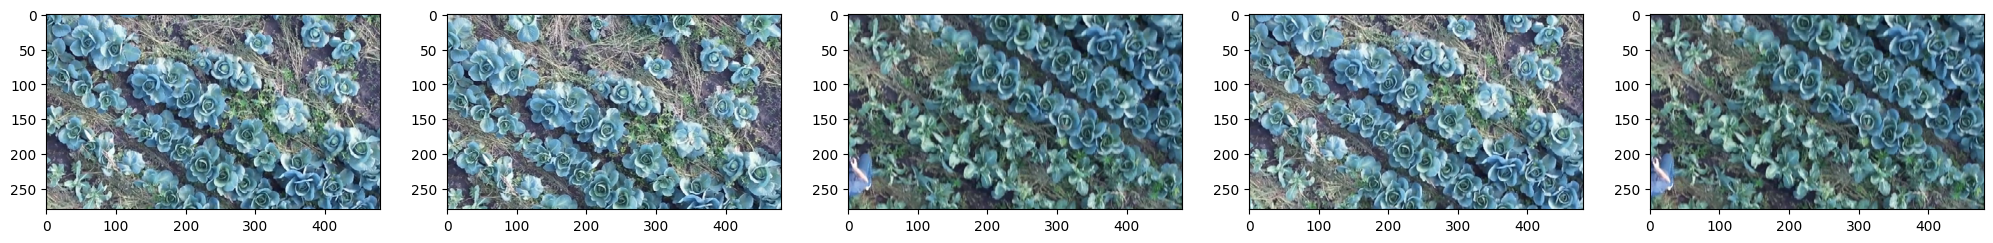

In [ ]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
    img = random.choice(trainIm) # Выбираем случайное фото для отображения
    axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

In [ ]:
trainSeg = [] # сейчас тут все карты сегментации

directory = '/content/semantic.v3.2/mask'
for filename in sorted(os.listdir(directory)):
    trainSeg.append(img_to_array(load_img(os.path.join(directory,filename), target_size=(280, 480))).astype('uint8')) # для всех сетей, кроме Unet with mask используем 280.

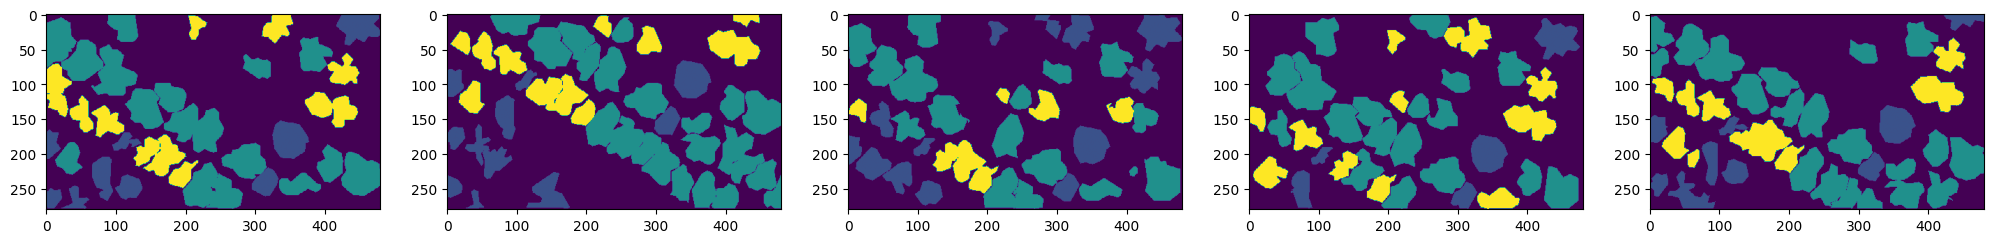

In [ ]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
    img = random.choice(trainSeg) # Выбираем случайное фото для отображения
    img = np.mean(img, axis=2)
    axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

# Make Train, Val

In [ ]:
# Преобразуем каждую из картинок в массив (высота, ширина, количество каналов)
XTrain = []
for img in trainIm:
  x = image.img_to_array(img)
  XTrain.append(x)

In [ ]:
# Т.к. картинок мало, то перемешиваем выборку под xTrain, yTrain
import random
numbers = list(range(0,20))
random.shuffle(numbers)
index_train = sorted(numbers[0:15])
index_val = sorted(numbers[15:])
print(index_train)
print(index_val)

[0, 1, 2, 3, 5, 7, 9, 10, 11, 12, 14, 15, 16, 18, 19]
[4, 6, 8, 13, 17]


In [ ]:
# Преобразуем каждую из картинок в массив (высота, ширина, количество каналов)
xAll = []
for img in trainIm:
  x = image.img_to_array(img)
  xAll.append(x)

In [ ]:
xAllnp = np.array(xAll)
xTrain = xAllnp[index_train]    # 15 перемешанных картинок в обучающую
xTest = xAllnp[index_val]       # 5 перемешанных в проверочную
print(xTrain.shape)
print(xTest.shape)

(15, 280, 480, 3)
(5, 280, 480, 3)


In [ ]:
# Аналалогично для карт сегментации
yAll = []

for seg in trainSeg:
    y = image.img_to_array(seg)
    yAll.append(y)

In [ ]:
yAllnp = np.array(yAll)
yTrain = yAllnp[index_train]
yTest = yAllnp[index_val]
print(yTrain.shape)
print(yTest.shape)

(15, 280, 480, 3)
(5, 280, 480, 3)


**Раскрашиваем сегментированную картинку**

In [ ]:
def mask_to_one_hot(mask, num_classes):
    # Создаем массив нулей размерностью (высота, ширина, количество классов)
    one_hot = np.zeros((*mask.shape, num_classes), dtype=np.uint8)
    # Проходимся по классам и устанавливаем соответствующий канал в 1, если маска равна классу
    for class_value in range(num_classes):
        one_hot[..., class_value] = (mask == class_value).astype(np.uint8)
    return one_hot

In [ ]:
# Имеем 5 классов [0,1,2,3,4]
num_classes = 5

In [ ]:
# Перекрашиваем сегментную карту в цвета по классам
outYTrain = mask_to_one_hot(yTrain, num_classes)
outYTest = mask_to_one_hot(yTest, num_classes)

# U-Net

In [ ]:
# Глобальные параметры
img_width = 280 # Ширина уменьшенной картинки
img_height = 480 # Высота уменьшенной картинки
num_classes = 5 # Задаем количество классов на изображении

In [ ]:
# Избавляемся от ненужной уже размерности RGB
outYTrain = np.mean(outYTrain, axis=3)
outYTest = np.mean(outYTest, axis=3)
print('outYTrain = ', outYTrain.shape)
print('outYTest = ', outYTest.shape)

outYTrain =  (15, 280, 480, 5)
outYTest =  (5, 280, 480, 5)


In [ ]:
# Все размерности согласованы
print('xTrain= ',xTrain.shape)
print('outYTrain= ', outYTrain.shape)
print('xTest= ', xTest.shape)
print('outYTest= ', outYTest.shape)

xTrain=  (15, 280, 480, 3)
outYTrain=  (15, 280, 480, 5)
xTest=  (5, 280, 480, 3)
outYTest=  (5, 280, 480, 5)


In [ ]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def UNet(num_classes = 3, input_shape= (88, 120, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                        # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                        # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                        # Добавляем слой MaxPooling2D

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                      # Объединем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                      # Объединем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = concatenate([x, block_1_out])  # Объединем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x) # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])

    return model # Возвращаем сформированную модель

In [ ]:
modelUNet = UNet(num_classes, (img_width, img_height, 3))

In [ ]:
from pandas.core.arrays import period
checkpoint = ModelCheckpoint('unet_model.hdf5', monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max', period=1)

In [ ]:
history = modelUNet.fit(xTrain, outYTrain, epochs=160, batch_size=8, validation_data = (xTest, outYTest), callbacks = [checkpoint])

Epoch 1/160
2/2 [==============================] - ETA: 0s - loss: 0.3849 - dice_coef: 0.7832
Epoch 1: val_dice_coef did not improve from 0.84832
2/2 [==============================] - 2s 1s/step - loss: 0.3849 - dice_coef: 0.7832 - val_loss: 63.3780 - val_dice_coef: 0.6089
Epoch 2/160
2/2 [==============================] - ETA: 0s - loss: 0.3502 - dice_coef: 0.7949
Epoch 2: val_dice_coef did not improve from 0.84832
2/2 [==============================] - 2s 1s/step - loss: 0.3502 - dice_coef: 0.7949 - val_loss: 118.2636 - val_dice_coef: 0.6024
Epoch 3/160
2/2 [==============================] - ETA: 0s - loss: 0.3324 - dice_coef: 0.8081
Epoch 3: val_dice_coef did not improve from 0.84832
2/2 [==============================] - 2s 1s/step - loss: 0.3324 - dice_coef: 0.8081 - val_loss: 53.8340 - val_dice_coef: 0.5772
Epoch 4/160
2/2 [==============================] - ETA: 0s - loss: 0.3058 - dice_coef: 0.8229
Epoch 4: val_dice_coef did not improve from 0.84832
2/2 [=======================

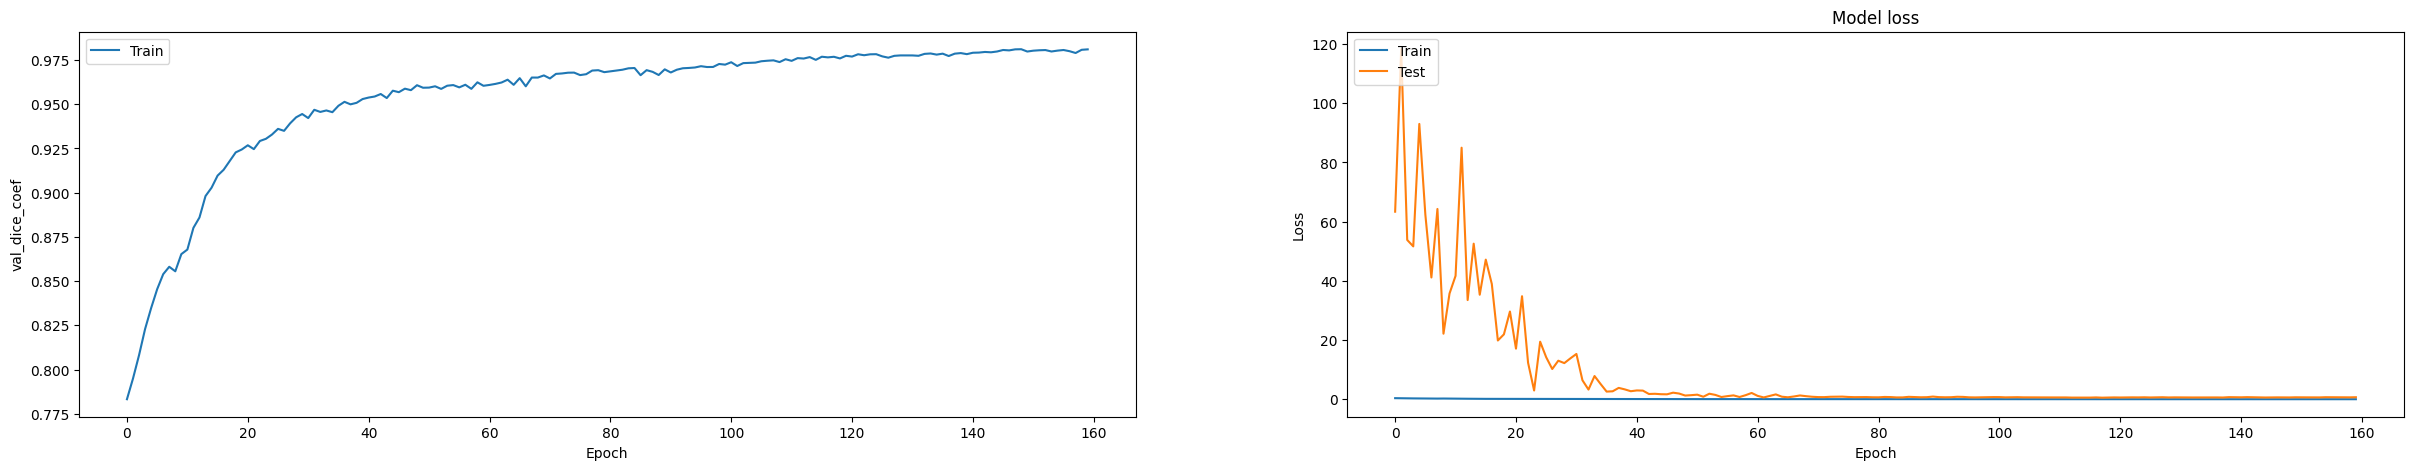

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
#plt.plot(history.history['loss'])
plt.plot(history.history['dice_coef'])
#plt.title('val_loss')
plt.ylabel('val_dice_coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 425ms/step


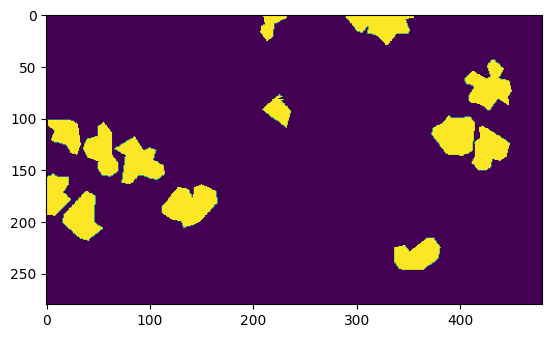

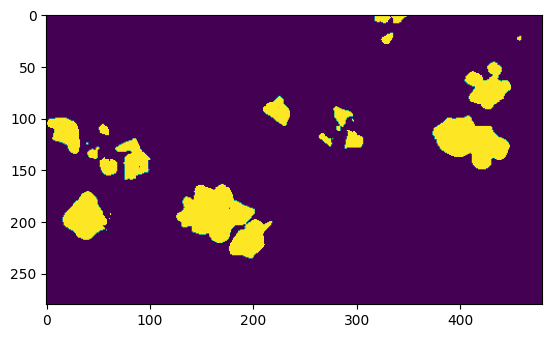

In [ ]:
modelUNet.load_weights('/content/unet_model.hdf5') # Подгружаем предобученные веса
pred =  modelUNet.predict(xTest[:10]) # Предсказываем тестовые картинки

# Сравним сгенерированную картинку сегментации с обучающей
n = 2
plt.imshow(outYTest[n][:,:,-1]) # mean (4)
plt.show()
img = 255*np.uint8(np.round(pred[n]))[:,:,-1]
plt.imshow(img)
plt.show()

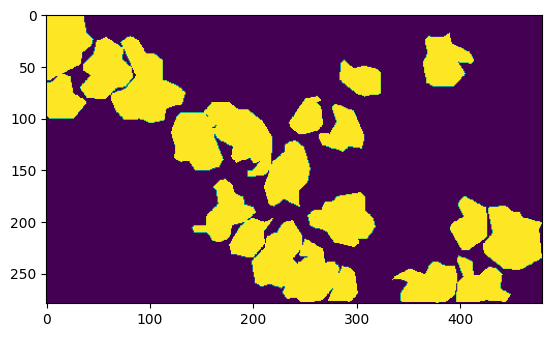

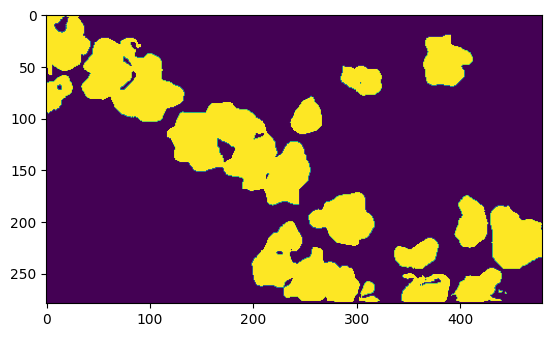

In [ ]:
plt.imshow(outYTest[n][1:,:,2]) # cool
plt.show()
img = 255*np.uint8(np.round(pred[n]))[1:,:,2]
plt.imshow(img)
plt.show()

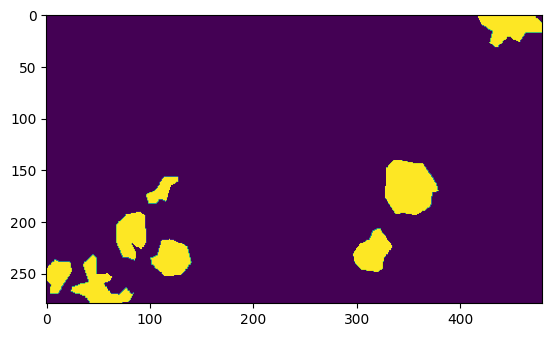

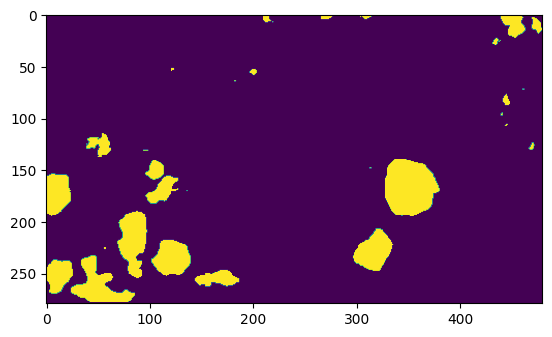

In [ ]:
plt.imshow(outYTest[n][1:,:,1]) # bad
plt.show()
img = 255*np.uint8(np.round(pred[n]))[1:,:,1]
plt.imshow(img)
plt.show()

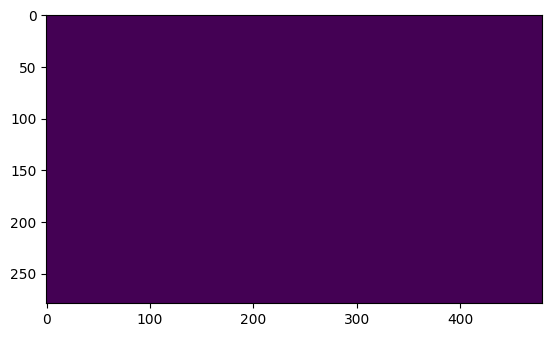

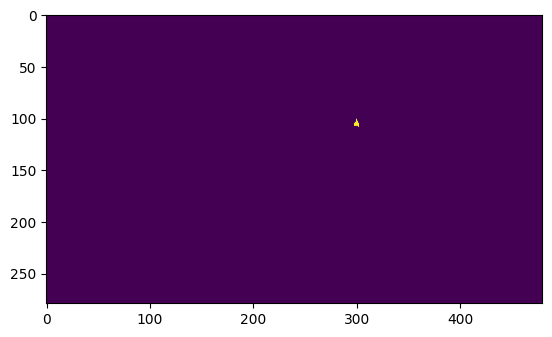

In [ ]:
plt.imshow(outYTest[n][1:,:,3]) # man
plt.show()
img = 255*np.uint8(np.round(pred[n]))[1:,:,3]
plt.imshow(img)
plt.show()

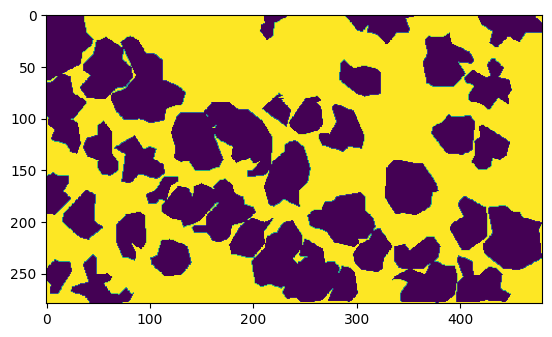

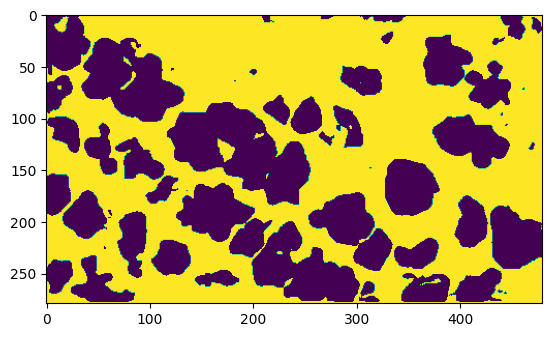

In [ ]:
plt.imshow(outYTest[n][1:,:,0]) # background
plt.show()
img = 255*np.uint8(np.round(pred[n]))[1:,:,0]
plt.imshow(img)
plt.show()

# PSPNet

In [ ]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def PSPNet(conv_size = 32, num_classes = 2, input_shape = (272, 480, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(conv_size, (3, 3), padding='same')(img_input)
    x = BatchNormalization()(x)
    x_c_1 = Activation('relu')(x)
    x = Conv2D(conv_size, (3, 3), padding='same')(x_c_1)
    x = BatchNormalization()(x)
    x_c_2 = Activation('relu')(x)
    x = x_c_2

    x_mp_2 = MaxPooling2D(2)(x)
    x_mp_4 = MaxPooling2D(4)(x)
    x_mp_8 = MaxPooling2D(8)(x)
    #x_mp_16 = MaxPooling2D(16)(x)
    #x_mp_32 = MaxPooling2D(32)(x)

    x_mp_2 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_2)
    x_mp_4 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_4)
    x_mp_8 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_8)
    #x_mp_16 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_16)
    #x_mp_32 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_32)

    x_mp_2 = Conv2DTranspose(conv_size, (2, 2), strides=(2, 2), activation='relu')(x_mp_2)
    x_mp_4 = Conv2DTranspose(conv_size, (4, 4), strides=(4, 4), activation='relu')(x_mp_4)
    x_mp_8 = Conv2DTranspose(conv_size, (8, 8), strides=(8, 8), activation='relu')(x_mp_8)
    #x_mp_16 = Conv2DTranspose(conv_size, (16, 16), strides=(16, 16), activation='relu')(x_mp_16)
    #x_mp_32 = Conv2DTranspose(conv_size, (32, 32), strides=(32, 32), activation='relu')(x_mp_32)

    #fin = concatenate([img_input, x_mp_2, x_mp_4, x_mp_8, x_mp_16, x_mp_32])
    fin = concatenate([img_input, x_c_1, x_c_2, x_mp_2, x_mp_4, x_mp_8])
    fin = Conv2D(conv_size, (3, 3), padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)
    fin = Conv2D(conv_size, (3, 3), padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)

    fin = Conv2D(num_classes-1, (3, 3), activation='softmax', padding='same')(fin)

    model = Model(img_input, fin)
    model.compile(optimizer=Adam(lr=1e-4),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    return model

In [ ]:
modelPSP = PSPNet(64, 6, (280, 480, 3))

In [ ]:
from pandas.core.arrays import period
checkpoint = ModelCheckpoint('psp_model.hdf5', monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max', period=1)

In [ ]:
modelPSP.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 280, 480, 3)]        0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 280, 480, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_19 (Ba  (None, 280, 480, 64)         256       ['conv2d_7[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 activation_19 (Activation)  (None, 280, 480, 64)         0         ['batch_normalization_19

In [ ]:
print('xTrain= ',xTrain.shape)
print('outYTrain= ', outYTrain.shape)
print('xTest= ', xTest.shape)
print('outYTest= ', outYTest.shape)

xTrain=  (15, 280, 480, 3)
outYTrain=  (15, 280, 480, 5)
xTest=  (5, 280, 480, 3)
outYTest=  (5, 280, 480, 5)


In [ ]:
# Избавляемся от ненужной уже размерности RGB
#outYTrain = np.mean(outYTrain, axis=3)
#outYTest = np.mean(outYTest, axis=3)
#print('otYTrain = ', outYTrain.shape)
#print('outYTest = ', outYTest.shape)

otYTrain =  (15, 280, 480, 5)
outYTest =  (5, 280, 480, 5)


In [ ]:
# Все размерности согласованы
print('xTrain= ',xTrain.shape)
print('outYTrain= ', outYTrain.shape)
print('xTest= ', xTest.shape)
print('outYTest= ', outYTest.shape)

xTrain=  (15, 280, 480, 3)
outYTrain=  (15, 280, 480, 5)
xTest=  (5, 280, 480, 3)
outYTest=  (5, 280, 480, 5)


In [ ]:
history = modelPSP.fit(xTrain, outYTrain, epochs=160, batch_size=5, validation_data = (xTest, outYTest), callbacks = [checkpoint])

Epoch 1/160
3/3 [==============================] - ETA: 0s - loss: 1.3443 - dice_coef: 0.3738
Epoch 1: val_dice_coef improved from -inf to 0.21938, saving model to psp_model.hdf5
3/3 [==============================] - 17s 661ms/step - loss: 1.3443 - dice_coef: 0.3738 - val_loss: 11.3615 - val_dice_coef: 0.2194
Epoch 2/160
3/3 [==============================] - ETA: 0s - loss: 0.8814 - dice_coef: 0.5805
Epoch 2: val_dice_coef improved from 0.21938 to 0.34216, saving model to psp_model.hdf5
3/3 [==============================] - 1s 528ms/step - loss: 0.8814 - dice_coef: 0.5805 - val_loss: 3.7658 - val_dice_coef: 0.3422
Epoch 3/160
3/3 [==============================] - ETA: 0s - loss: 0.7913 - dice_coef: 0.6116
Epoch 3: val_dice_coef did not improve from 0.34216
3/3 [==============================] - 1s 488ms/step - loss: 0.7913 - dice_coef: 0.6116 - val_loss: 7.6516 - val_dice_coef: 0.1107
Epoch 4/160
3/3 [==============================] - ETA: 0s - loss: 0.7361 - dice_coef: 0.6224
Epoc

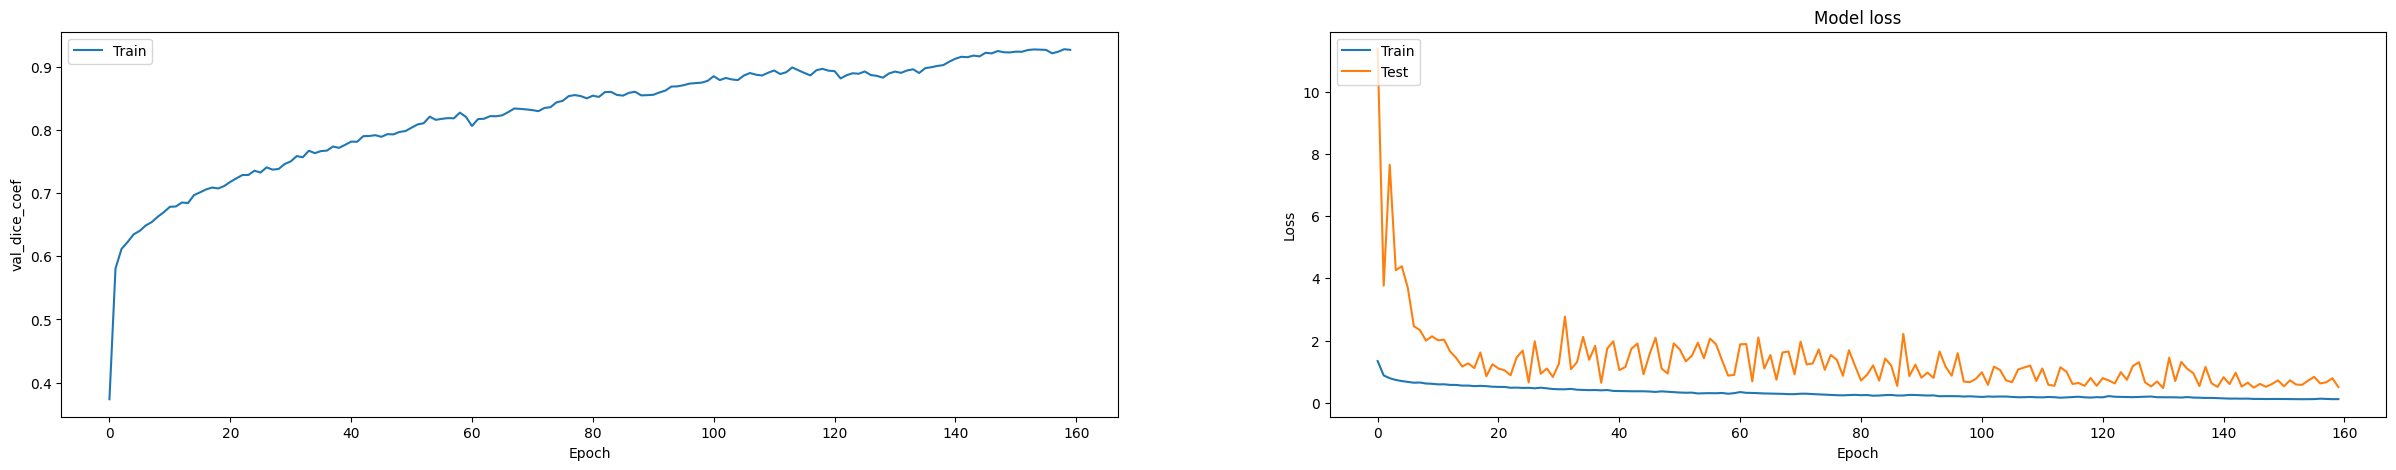

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
#plt.plot(history.history['loss'])
plt.plot(history.history['dice_coef'])
#plt.title('val_loss')
plt.ylabel('val_dice_coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 174ms/step


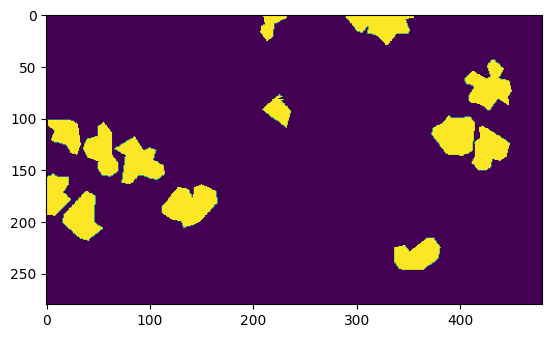

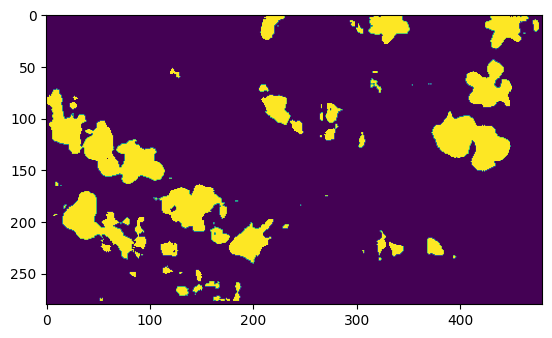

In [ ]:
modelPSP.load_weights('/content/psp_model.hdf5') # Подгружаем предобученные веса
pred = modelPSP.predict(xTest[:10]) # Предсказываем тестовые картинки

# Сравним сгенерированную картинку сегментации с обучающей
n = 2
plt.imshow(outYTest[n][:,:,-1])
plt.show()
img = 255*np.uint8(np.round(pred[n]))[:,:,-1]
plt.imshow(img)
plt.show()

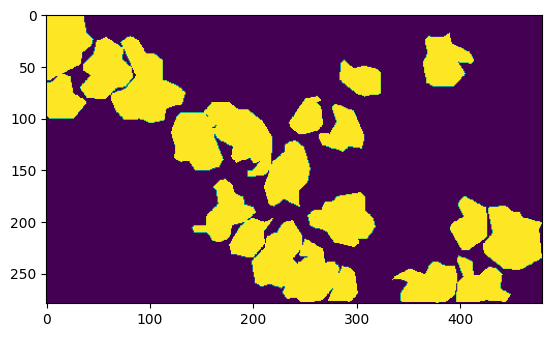

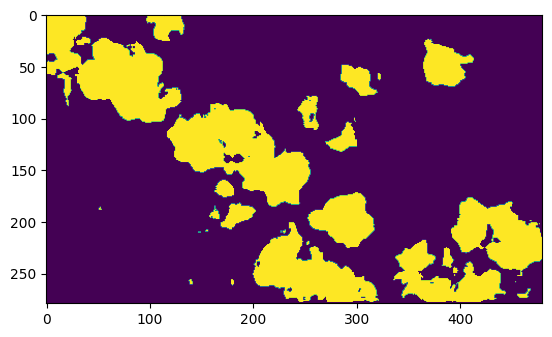

In [ ]:
plt.imshow(outYTest[n][1:,:,2])
plt.show()
img = 255*np.uint8(np.round(pred[n]))[1:,:,2]
plt.imshow(img)
plt.show()

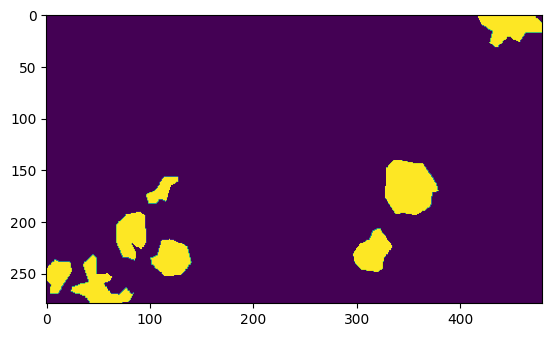

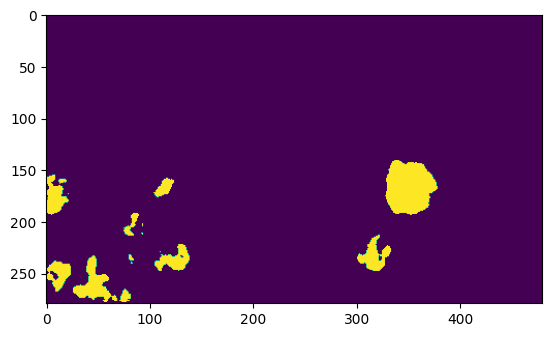

In [ ]:
plt.imshow(outYTest[n][1:,:,1])
plt.show()
img = 255*np.uint8(np.round(pred[n]))[1:,:,1]
plt.imshow(img)
plt.show()

# PSPNet расширенная

In [ ]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def PSPNet_2(conv_size = 32, num_classes = 2, input_shape = (272, 480, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(conv_size, (3, 3), padding='same')(img_input)
    x = BatchNormalization()(x)
    x_c_1 = Activation('relu')(x)

    x = Conv2D(conv_size, (3, 3), padding='same')(x_c_1)
    x = BatchNormalization()(x)
    x_c_2 = Activation('relu')(x)
    x = x_c_2

    x_mp_2 = MaxPooling2D(2)(x)
    x_mp_4 = MaxPooling2D(4)(x)
    x_mp_8 = MaxPooling2D(8)(x)

    x_mp_2 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_2)
    x_mp_4 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_4)
    x_mp_8 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_8)

    x_mp_2 = Conv2DTranspose(conv_size, (2, 2), strides=(2, 2), activation='relu')(x_mp_2)
    x_mp_4 = Conv2DTranspose(conv_size, (4, 4), strides=(4, 4), activation='relu')(x_mp_4)
    x_mp_8 = Conv2DTranspose(conv_size, (8, 8), strides=(8, 8), activation='relu')(x_mp_8)

    fin = concatenate([img_input, x_c_1, x_c_2, x_mp_2, x_mp_4, x_mp_8])
    fin = Conv2D(conv_size, (3, 3), padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin_c_1 = Activation('relu')(fin)
    fin = Conv2D(conv_size, (3, 3), padding='same')(fin_c_1)
    fin = BatchNormalization()(fin)
    fin_c_2 = Activation('relu')(fin)
    x = fin_c_2

    x_mp_2_1 = MaxPooling2D(2)(x)
    x_mp_4_1 = MaxPooling2D(4)(x)
    x_mp_8_1 = MaxPooling2D(8)(x)

    x_mp_2_1 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_2_1)
    x_mp_4_1 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_4_1)
    x_mp_8_1 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_8_1)

    x_mp_2_1 = Conv2DTranspose(conv_size, (2, 2), strides=(2, 2), activation='relu')(x_mp_2_1)
    x_mp_4_1 = Conv2DTranspose(conv_size, (4, 4), strides=(4, 4), activation='relu')(x_mp_4_1)
    x_mp_8_1 = Conv2DTranspose(conv_size, (8, 8), strides=(8, 8), activation='relu')(x_mp_8_1)

    fin = concatenate([img_input, x_c_1, x_c_2, fin, fin_c_1, fin_c_2, x_mp_2, x_mp_4, x_mp_8, x_mp_2_1, x_mp_4_1, x_mp_8_1])
    fin = Conv2D(conv_size, (3, 3), padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)
    fin = Conv2D(conv_size, (3, 3), padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)

    fin = Conv2D(num_classes-1, (3, 3), activation='sigmoid', padding='same')(fin)

    model = Model(img_input, fin)
    model.compile(optimizer=Adam(lr=1e-4),
                  loss='binary_crossentropy',
                  metrics=[dice_coef])
    return model

In [ ]:
modelPSP_2 = PSPNet_2(64, 6, (280, 480, 3))
from pandas.core.arrays import period
checkpoint = ModelCheckpoint('psp_model_2.hdf5', monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max', period=1)
modelPSP_2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 280, 480, 3)]        0         []                            
                                                                                                  
 conv2d_28 (Conv2D)          (None, 280, 480, 64)         1792      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_29 (Ba  (None, 280, 480, 64)         256       ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_29 (Activation)  (None, 280, 480, 64)         0         ['batch_normalization_29

In [ ]:
history = modelPSP_2.fit(xTrain, outYTrain, epochs=160, batch_size=5, validation_data = (xTest, outYTest), callbacks = [checkpoint])

Epoch 1/160
3/3 [==============================] - ETA: 0s - loss: 0.5493 - dice_coef: 0.4139
Epoch 1: val_dice_coef improved from -inf to 0.51100, saving model to psp_model_2.hdf5
3/3 [==============================] - 28s 1s/step - loss: 0.5493 - dice_coef: 0.4139 - val_loss: 1.1279 - val_dice_coef: 0.5110
Epoch 2/160
3/3 [==============================] - ETA: 0s - loss: 0.3596 - dice_coef: 0.5033
Epoch 2: val_dice_coef did not improve from 0.51100
3/3 [==============================] - 3s 1s/step - loss: 0.3596 - dice_coef: 0.5033 - val_loss: 1.2743 - val_dice_coef: 0.4706
Epoch 3/160
3/3 [==============================] - ETA: 0s - loss: 0.2860 - dice_coef: 0.5599
Epoch 3: val_dice_coef did not improve from 0.51100
3/3 [==============================] - 3s 1s/step - loss: 0.2860 - dice_coef: 0.5599 - val_loss: 1.3929 - val_dice_coef: 0.2800
Epoch 4/160
3/3 [==============================] - ETA: 0s - loss: 0.2561 - dice_coef: 0.5942
Epoch 4: val_dice_coef did not improve from 0.51

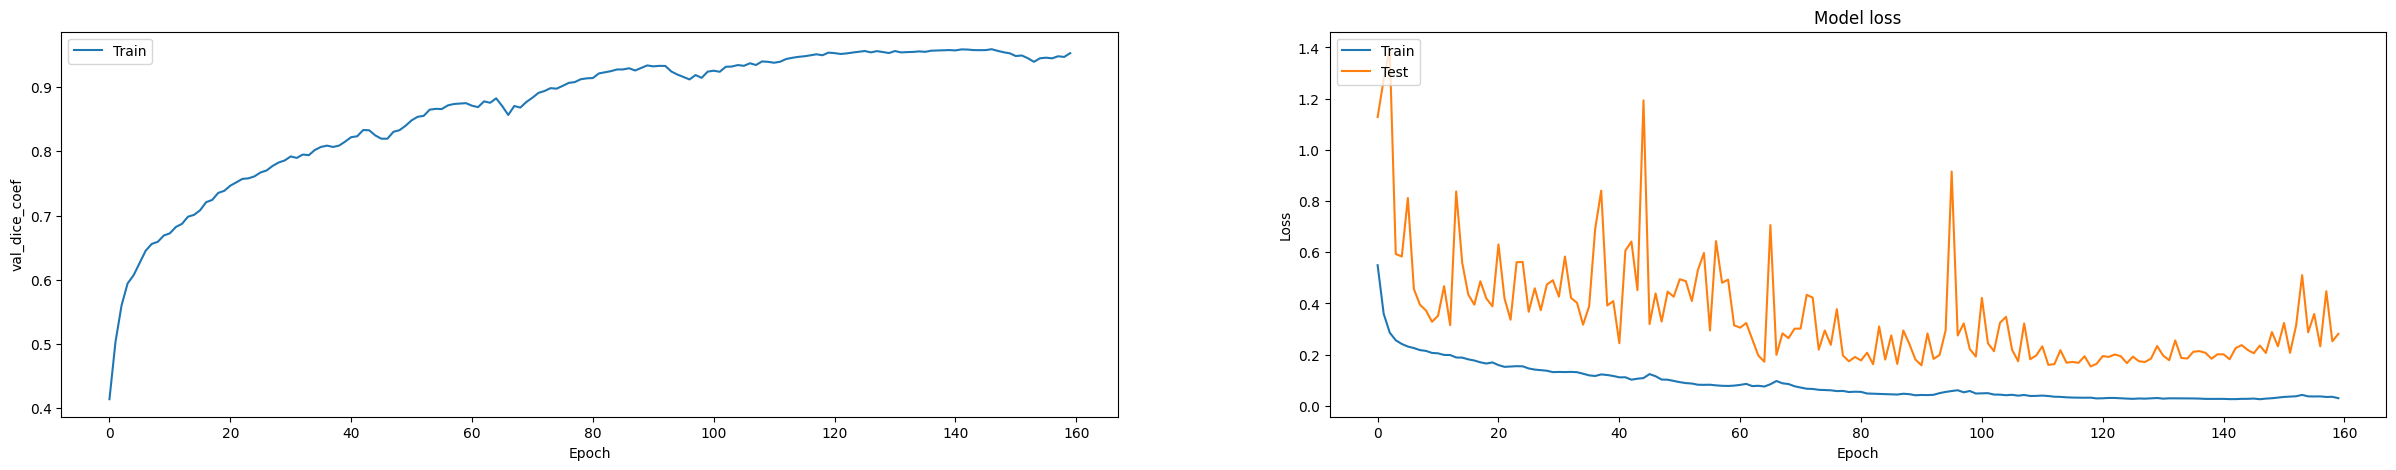

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
#plt.plot(history.history['loss'])
plt.plot(history.history['dice_coef'])
#plt.title('val_loss')
plt.ylabel('val_dice_coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 303ms/step


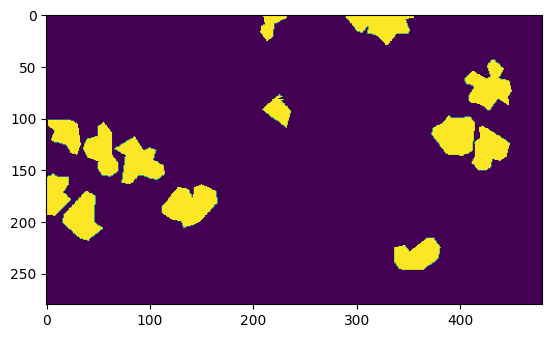

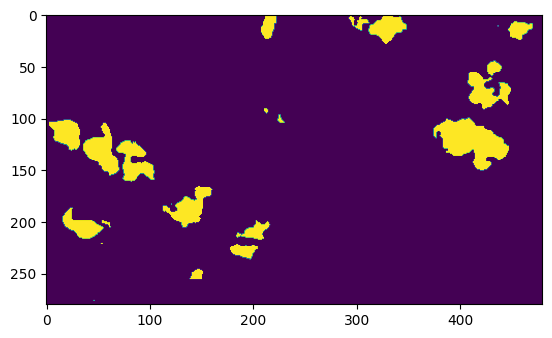

In [ ]:
modelPSP_2.load_weights('/content/psp_model_2.hdf5') # Подгружаем предобученные веса
pred = modelPSP_2.predict(xTest[:10]) # Предсказываем тестовые картинки

# Сравним сгенерированную картинку сегментации с обучающей
n = 2
plt.imshow(outYTest[n][:,:,-1])
plt.show()
img = 255*np.uint8(np.round(pred[n]))[:,:,-1]
plt.imshow(img)
plt.show()

# PSPNet Расширенная. conv_size = 32

In [ ]:
modelPSP_2_32 = PSPNet_2(32, 6, (280, 480, 3))
from pandas.core.arrays import period
checkpoint = ModelCheckpoint('psp_model_2_32.hdf5', monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max', period=1)
modelPSP_2_32.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 280, 480, 3)]        0         []                            
                                                                                                  
 conv2d_54 (Conv2D)          (None, 280, 480, 32)         896       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_41 (Ba  (None, 280, 480, 32)         128       ['conv2d_54[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_41 (Activation)  (None, 280, 480, 32)         0         ['batch_normalization_41

In [ ]:
history = modelPSP_2_32.fit(xTrain, outYTrain, epochs=120, batch_size=5, validation_data = (xTest, outYTest), callbacks = [checkpoint])

Epoch 1/120
3/3 [==============================] - ETA: 0s - loss: 0.7377 - dice_coef: 0.2798
Epoch 1: val_dice_coef improved from -inf to 0.16292, saving model to psp_model_2_32.hdf5
3/3 [==============================] - 20s 872ms/step - loss: 0.7377 - dice_coef: 0.2798 - val_loss: 4.5820 - val_dice_coef: 0.1629
Epoch 2/120


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - ETA: 0s - loss: 0.5621 - dice_coef: 0.3559
Epoch 2: val_dice_coef did not improve from 0.16292
3/3 [==============================] - 1s 463ms/step - loss: 0.5621 - dice_coef: 0.3559 - val_loss: 1.6214 - val_dice_coef: 0.1271
Epoch 3/120
3/3 [==============================] - ETA: 0s - loss: 0.4621 - dice_coef: 0.4012
Epoch 3: val_dice_coef did not improve from 0.16292
3/3 [==============================] - 1s 432ms/step - loss: 0.4621 - dice_coef: 0.4012 - val_loss: 1.2693 - val_dice_coef: 0.0196
Epoch 4/120
3/3 [==============================] - ETA: 0s - loss: 0.3920 - dice_coef: 0.4424
Epoch 4: val_dice_coef did not improve from 0.16292
3/3 [==============================] - 1s 431ms/step - loss: 0.3920 - dice_coef: 0.4424 - val_loss: 1.1343 - val_dice_coef: 0.0419
Epoch 5/120
3/3 [==============================] - ETA: 0s - loss: 0.3446 - dice_coef: 0.4793
Epoch 5: val_dice_coef did not improve from 0.16292
3/3 [==============================

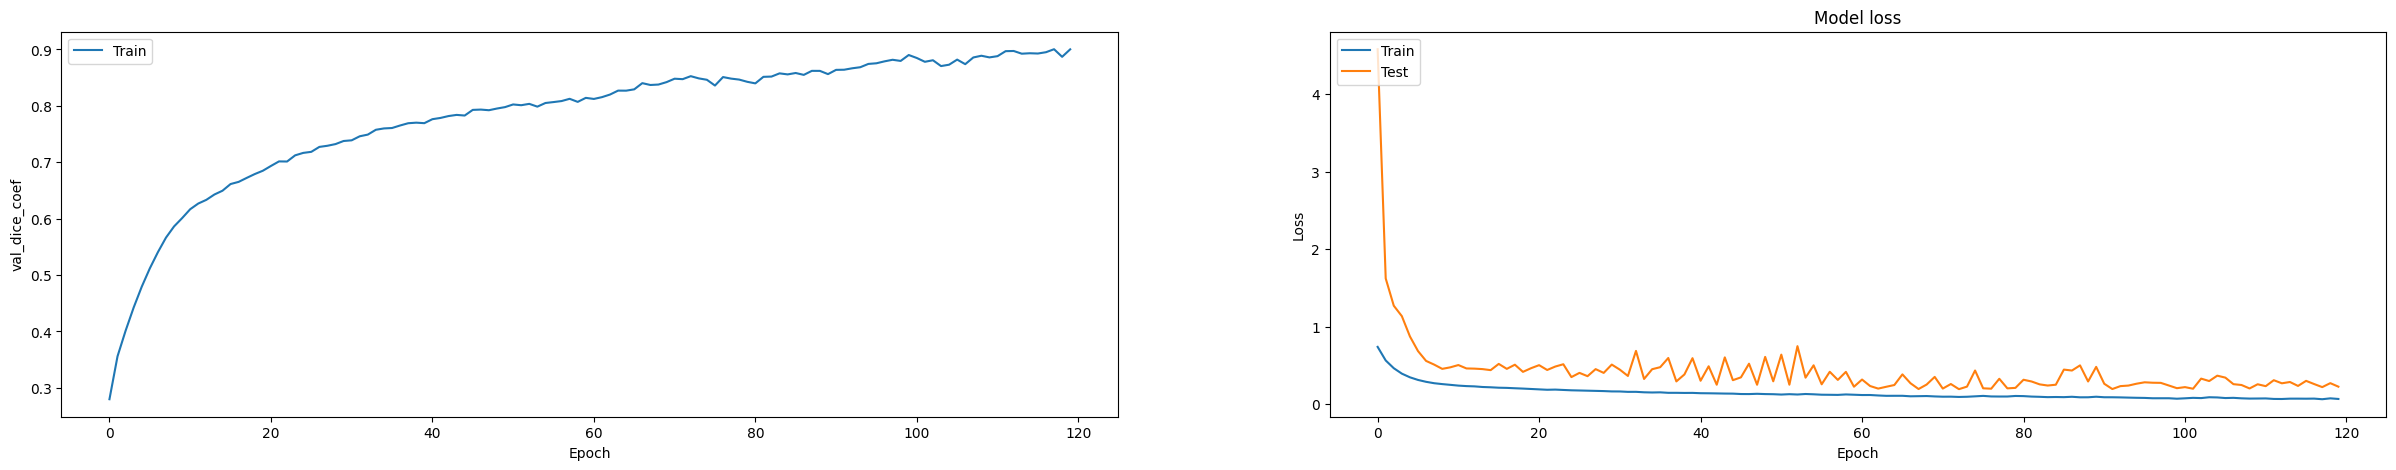

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
#plt.plot(history.history['loss'])
plt.plot(history.history['dice_coef'])
#plt.title('val_loss')
plt.ylabel('val_dice_coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 21ms/step


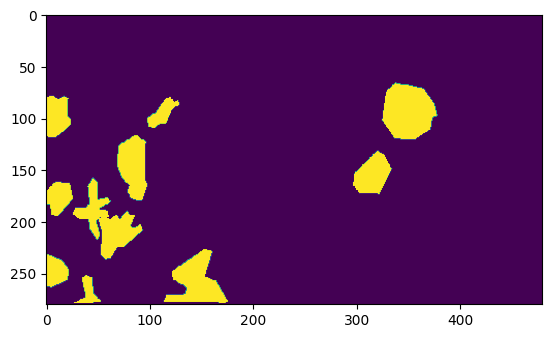

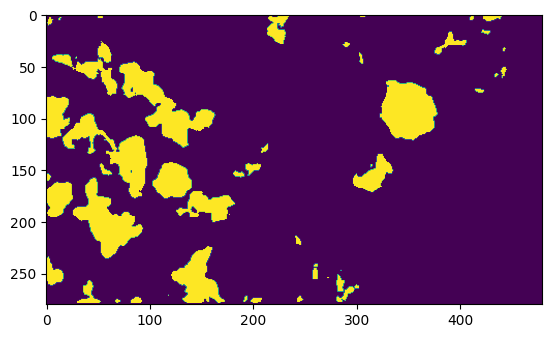

In [ ]:
modelPSP_2_32.load_weights('/content/psp_model_2_32.hdf5') # Подгружаем предобученные веса
predPSP_2_32 = modelPSP_2_32.predict(xTest[:1]) # Предсказываем тестовые картинки

# Сравним сгенерированную картинку сегментации с обучающей
n = 0
plt.imshow(outYTest[n][:,:,1])
plt.show()
img = 255*np.uint8(np.round(predPSP_2_32[n]))[:,:,1]
plt.imshow(img)
plt.show()